## 치킨 예측하기
- 배그 최후의 생존자 = 치킨 예측하기 train 데이터를 통해 치킨을 가장 잘 예측할 수 있는 모델을 만들어서 test 데이터에 적용시 높은 치킨 예측도를 가지면 된다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [5]:
# train data load
train_df = pd.read_csv('../data/pubg-finish-placement-prediction/train_V2.csv', index_col="Id") 

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4446966 entries, 7f96b2f878858a to 0d8e7ed728b6fd
Data columns (total 25 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int64  
 1   boosts           int64  
 2   damageDealt      float64
 3   DBNOs            int64  
 4   headshotKills    int64  
 5   heals            int64  
 6   killPlace        int64  
 7   killPoints       int64  
 8   kills            int64  
 9   killStreaks      int64  
 10  longestKill      float64
 11  matchDuration    int64  
 12  maxPlace         int64  
 13  numGroups        int64  
 14  rankPoints       int64  
 15  revives          int64  
 16  rideDistance     float64
 17  roadKills        int64  
 18  swimDistance     float64
 19  teamKills        int64  
 20  vehicleDestroys  int64  
 21  walkDistance     float64
 22  weaponsAcquired  int64  
 23  winPoints        int64  
 24  winPlacePerc     float64
dtypes: float64(6), int64(19)
memory usage: 882.1+ MB


In [7]:
# test data load
test_df = pd.read_csv('../data/pubg-finish-placement-prediction/test_V2.csv', index_col="Id") 

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1934174 entries, 9329eb41e215eb to 3696fc9f3a42b2
Data columns (total 24 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int64  
 1   boosts           int64  
 2   damageDealt      float64
 3   DBNOs            int64  
 4   headshotKills    int64  
 5   heals            int64  
 6   killPlace        int64  
 7   killPoints       int64  
 8   kills            int64  
 9   killStreaks      int64  
 10  longestKill      float64
 11  matchDuration    int64  
 12  maxPlace         int64  
 13  numGroups        int64  
 14  rankPoints       int64  
 15  revives          int64  
 16  rideDistance     float64
 17  roadKills        int64  
 18  swimDistance     float64
 19  teamKills        int64  
 20  vehicleDestroys  int64  
 21  walkDistance     float64
 22  weaponsAcquired  int64  
 23  winPoints        int64  
dtypes: float64(5), int64(19)
memory usage: 368.9+ MB


In [17]:
train_df.shape

(4446966, 25)

In [18]:
test_df.shape

(1934174, 24)

In [16]:
# object type 제거

del train_df['groupId']
del train_df['matchId']
del train_df['matchType']

del test_df['groupId']
del test_df['matchId']
del test_df['matchType']

## Explore

In [15]:
%matplotlib inline

In [21]:
train_df.keys() 
#        'assists' :팀원의 킬을 하는 중 같이 데미지를 입힌 횟수, 'boosts' : 사용한 부스트 아이템 수, 'damageDealt' : 딜량의 총합,  
#        'DBNOs' 기절시킨 적의 수 , 'headshotKills' 헤드샷으로 죽인 적의 수, 'heals' 사용한 치료 아이템 수,
#        'killPlace' 킬 수로 낸 등수, 'killPoints' 킬 포인트, 'kills' 킬 수, 'killStreaks' 다른 id가 킬을 하기 전에 연속으로 한 킬수, 
#        'longestKill' 사망시 사망 한 플레이어와 플레이어 사이의 최장 거리. 플레이어를 쓰러 뜨리고 도망 가면 가장 큰 킬 스탯이 생길 수 있으므로 오해의 소지가 있습니다. ,
#        'matchDuration' 매치 시간, 'maxPlace' 매치 내에서 가장 낮은 등수

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')

### Pearson correlation between variables

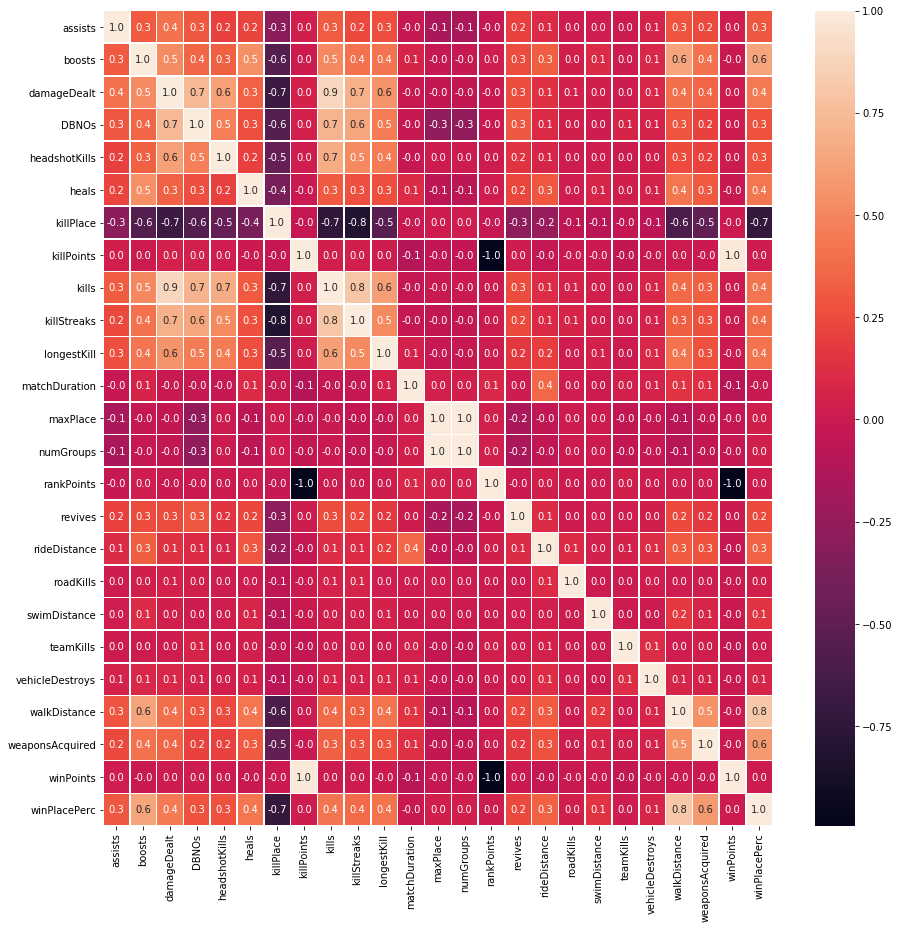

In [23]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

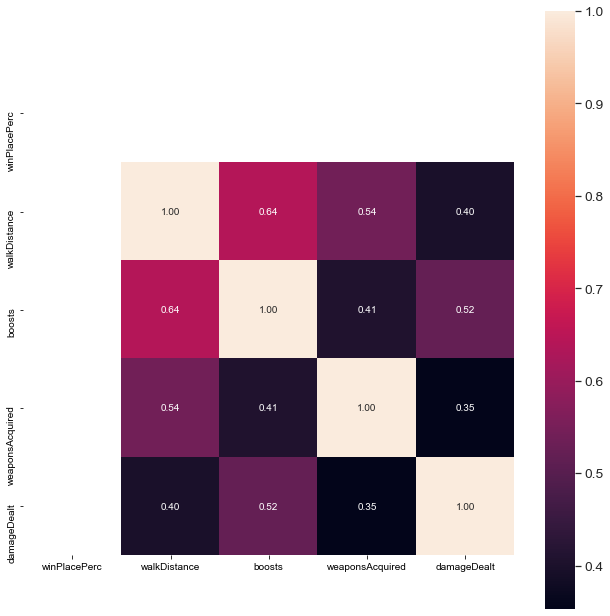

In [24]:
k = 5 #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = train_df.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### plot kill counts and dealing damege

In [25]:
print("The average person kills {:.4f} players, 99% of people have {} kills or less, while the most kills ever recorded is {}.".format(train_df['kills'].mean(), train_df['kills'].quantile(0.99), train_df['kills'].max()))

The average person kills 0.9248 players, 99% of people have 7.0 kills or less, while the most kills ever recorded is 72.


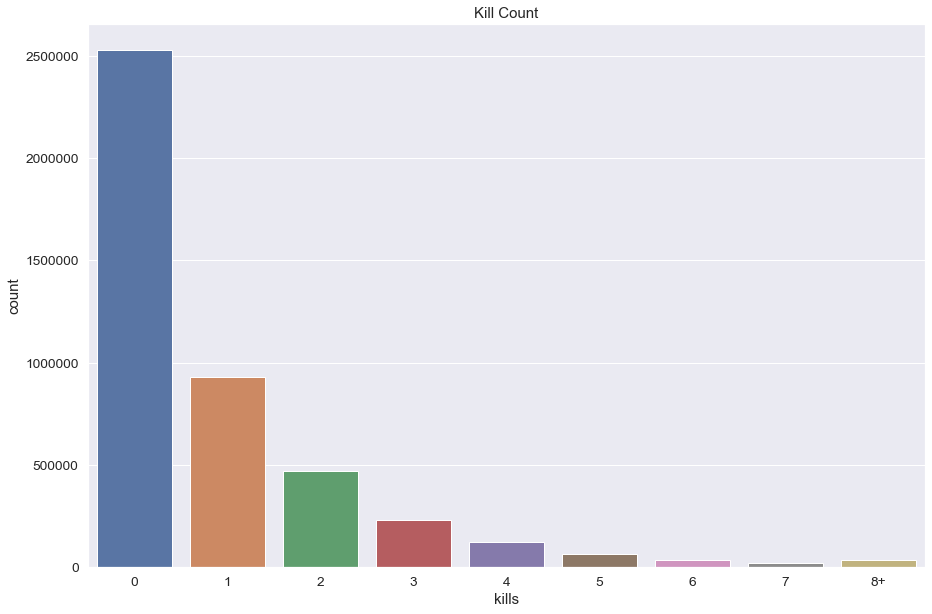

In [28]:
data = train_df.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()

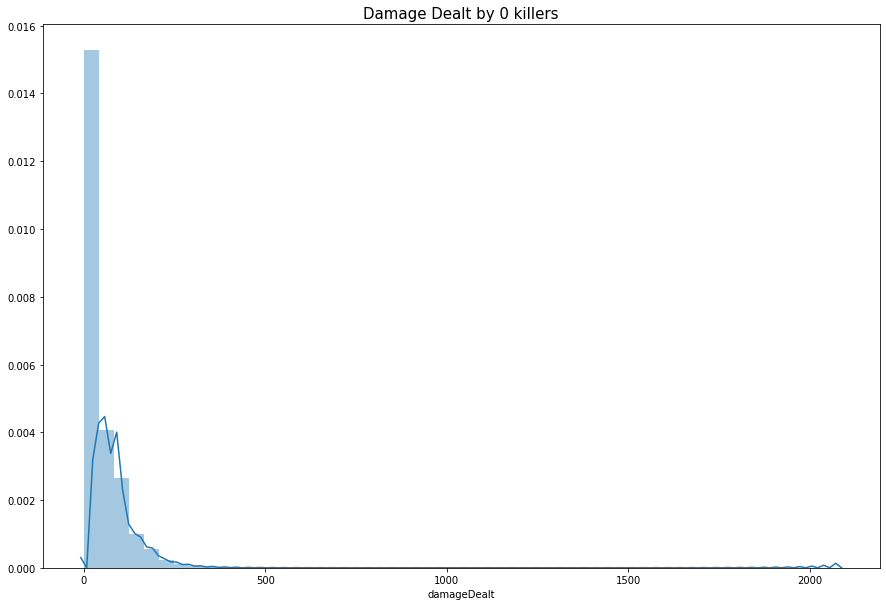

In [22]:
# Most people can't make a single kill. At least do they do damage?

data = train_df.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,10))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

In [31]:
print("{} players ({:.4f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(train_df)))

114089 players (2.5655%) have won without a single kill!


In [34]:
data1 = train_df[train_df['damageDealt'] == 0].copy()
print("{} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train_df)))

4770 players (0.1073%) have won without dealing damage!


In [35]:
len(data1[data1['winPlacePerc']==1])

4770

In [36]:
data2 = train_df[train_df['winPlacePerc'] == 1].copy()

In [38]:
data2.shape

(127573, 25)

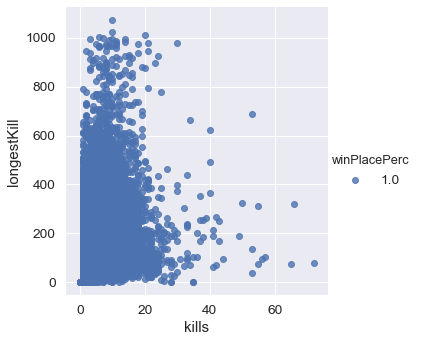

In [39]:
sns.lmplot(data=data2, x="kills", y="longestKill", hue="winPlacePerc", fit_reg=False)

In [56]:
train_df[train_df["winPlacePerc"].isnull()]

KeyError: 'winPlacePerc'

In [54]:
train_df = train_df.dropna() #nan값 drop시켜줌
test_df = test_df.dropna() #nan값 drop시켜줌


- Label: 레이블(Label), 내지는 타겟 변수(Target Variable)이라고 부릅니다. (몇몇 곳에서는 Class라고도 부릅니다) 쉽게 말해 우리가 맞춰야 하는 정답입니다. 타이타닉 경진대회에서는 생존 여부(Survived)가 label이 되겠죠.
- Feature: 우리가 label을 맞추는데 도움이 되는 값들입니다. 타이타닉 데이터에서는 label을 제외한 대부분의 값들이 Feature가 될 수 있습니다.

- Label : 치킨확률(winPlacePerc)
- Feature : 1) kills, 2) walkDistance, 3) boosts, 4) headshotKills, 5) longestKill, 6) heals

In [57]:
feature_names = ["kills", "walkDistance", "boosts",
                 "headshotKills", "longestKill", "heals"]

feature_names

['kills', 'walkDistance', 'boosts', 'headshotKills', 'longestKill', 'heals']

In [58]:
label_name = "winPlacePerc"
label_name

'winPlacePerc'

In [61]:
# feature_names를 활용해 train 데이터의 feature를 가져옵니다.
# 이를 X_train이라는 이름의 변수에 할당합니다.
X_train = train_df[feature_names]

# X_train 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(X_train.shape)
# 여기서데이터를 데이터를데이터를   
# X_train 데이터의 상위 5개를 띄웁니다.
X_train.head()

(4446965, 6)


,kills,walkDistance,boosts,headshotKills,longestKill,heals
Id,,,,,,
7f96b2f878858a,0,244.80,0,0,0.00,0
eef90569b9d03c,0,1434.00,0,0,0.00,0
1eaf90ac73de72,0,161.80,0,0,0.00,0
4616d365dd2853,0,202.70,0,0,0.00,0
315c96c26c9aac,1,49.75,0,0,58.53,0


In [64]:
X_test = test_df[feature_names]
# X_test 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(X_test.shape)

# X_test 데이터의 상위 5개를 띄웁니다.
X_test.head()

(1934174, 6)


,kills,walkDistance,boosts,headshotKills,longestKill,heals
Id,,,,,,
9329eb41e215eb,0,588.0,0,0,0.00,0
639bd0dcd7bda8,2,2017.0,4,0,361.90,2
63d5c8ef8dfe91,0,787.8,0,0,0.00,4
cf5b81422591d1,0,1812.0,0,0,0.00,0
ee6a295187ba21,3,2963.0,4,2,60.06,1


In [65]:
# label_name을 활용해 train 데이터의 label을 가져옵니다.
# 이를 y_train이라는 이름의 변수에 할당합니다.
y_train = train_df[label_name]

# y_train 변수에 할당된 데이터의 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시되나, column이 없기 때문에 (row,) 형태로 표시될 것입니다.
print(y_train.shape)

# y_train 데이터의 상위 5개를 띄웁니다.
y_train.head()

(4446965,)


Id
7f96b2f878858a    0.4444
eef90569b9d03c    0.6400
1eaf90ac73de72    0.7755
4616d365dd2853    0.1667
315c96c26c9aac    0.1875
Name: winPlacePerc, dtype: float64

In [66]:
from sklearn.tree import DecisionTreeRegressor

In [67]:
model = DecisionTreeRegressor(max_depth=8, random_state=0)
model

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [68]:
# DecisionTreeClassifier를 학습(fitting)합니다.
# 학습에는 fit 이라는 기능을 사용하며, train 데이터의 feature(X_train)와 label(y_train)을 집어넣습니다.
model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [70]:
# graphviz 모듈을 가져옵니다.
import graphviz

# scikit-learn(줄여서 sklearn)의 tree 모듈에서 Decision Tree를 시각화 할 수 있는 export_graphviz를 가져옵니다.
from sklearn.tree import export_graphviz

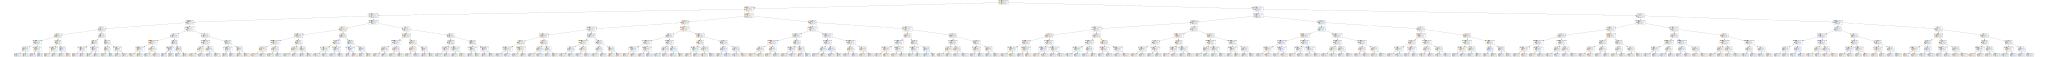

In [71]:
# export_graphviz로 Decision Tree를 시각화합니다. 시각화 할 때는 다음의 옵션이 들어갑니다.
# 1) model. 시각화할 트리(Decision Tree) 입니다.
# 2) feature_names. 트리를 만들 때 사용한 feature들의 이름입니다.
# 3) class_names. 살았을 경우 시각화에서 어떻게 표현할 것인지(Survived), 반대로 죽었을 경우 시각화에서 어떻게 표현할 것인지(Perish)를 알려줍니다.
# 4) out_file. 시각화 겨롸를 저장할 파일명입니다. 이번에는 파일로 저장하지 않고 바로 쥬피터 노트북에 띄울 생각이므로 None을 주면 됩니다.
# 마지막으로 시각화한 결과를 dot_tree라는 이름의 변수에 저장합니다.
dot_tree = export_graphviz(model,
                           feature_names=feature_names,
                           class_names=["Perish", "winPlacePerc"],
                           out_file=None)

# graphviz에서 Source라는 기능을 통해 Decision Tree를 시각화합니다.
graphviz.Source(dot_tree)

In [72]:
# fit이 끝났으면, predict라는 기능을 사용하여 생존 여부(Survived)를 예측합니다.
# predict의 실행이 끝나면 test 데이터의 생존 여부(Survived)를 반환하며, 이를 predictions라는 이름의 변수에 할당합니다.
predictions = model.predict(X_test)

# predictions 변수에 할당된 데이터의 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시되나, column이 없기 때문에 (row,) 형태로 표시될 것입니다.
print(predictions.shape)

# predictions 변수에 값이 너무 많기 때문에, 상위 10개만 출력합니다.
predictions[0:10]

(1934174,)


array([0.3769276 , 0.79517561, 0.45327953, 0.63147319, 0.88255634,
       0.03639631, 0.61531773, 0.5351382 , 0.55716787, 0.60754121])

In [73]:
X_test

,kills,walkDistance,boosts,headshotKills,longestKill,heals
Id,,,,,,
9329eb41e215eb,0,588.00,0,0,0.00,0
639bd0dcd7bda8,2,2017.00,4,0,361.90,2
63d5c8ef8dfe91,0,787.80,0,0,0.00,4
cf5b81422591d1,0,1812.00,0,0,0.00,0
ee6a295187ba21,3,2963.00,4,2,60.06,1
...,...,...,...,...,...,...
a316c3a13887d5,4,1799.00,2,0,69.27,7
5312146b27d875,0,1195.00,0,0,0.00,0
fc8818b5b32ad3,1,3327.00,0,0,25.38,3


In [82]:
X_train

,kills,walkDistance,boosts,headshotKills,longestKill,heals
Id,,,,,,
7f96b2f878858a,0,244.80,0,0,0.00,0
eef90569b9d03c,0,1434.00,0,0,0.00,0
1eaf90ac73de72,0,161.80,0,0,0.00,0
4616d365dd2853,0,202.70,0,0,0.00,0
315c96c26c9aac,1,49.75,0,0,58.53,0
...,...,...,...,...,...,...
afff7f652dbc10,0,1019.00,0,0,0.00,0
f4197cf374e6c0,0,81.70,1,0,0.00,0
e1948b1295c88a,0,788.70,0,0,0.00,0


In [79]:
y_train

Id
7f96b2f878858a    0.4444
eef90569b9d03c    0.6400
1eaf90ac73de72    0.7755
4616d365dd2853    0.1667
315c96c26c9aac    0.1875
                   ...  
afff7f652dbc10    0.1786
f4197cf374e6c0    0.2935
e1948b1295c88a    0.4815
cc032cdd73b7ac    0.8000
0d8e7ed728b6fd    0.5464
Name: winPlacePerc, Length: 4446965, dtype: float64

In [81]:
train_df.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
Id,,,,,,,,,,,,,,,,,,,,,
7f96b2f878858a,0,0,0.00,0,0,0,60,1241,0,0,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
eef90569b9d03c,0,0,91.47,0,0,0,57,0,0,0,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
1eaf90ac73de72,1,0,68.00,0,0,0,47,0,0,0,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
4616d365dd2853,0,0,32.90,0,0,0,75,0,0,0,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
315c96c26c9aac,0,0,100.00,0,0,0,45,0,1,1,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


## winPlacePerc vs Kills

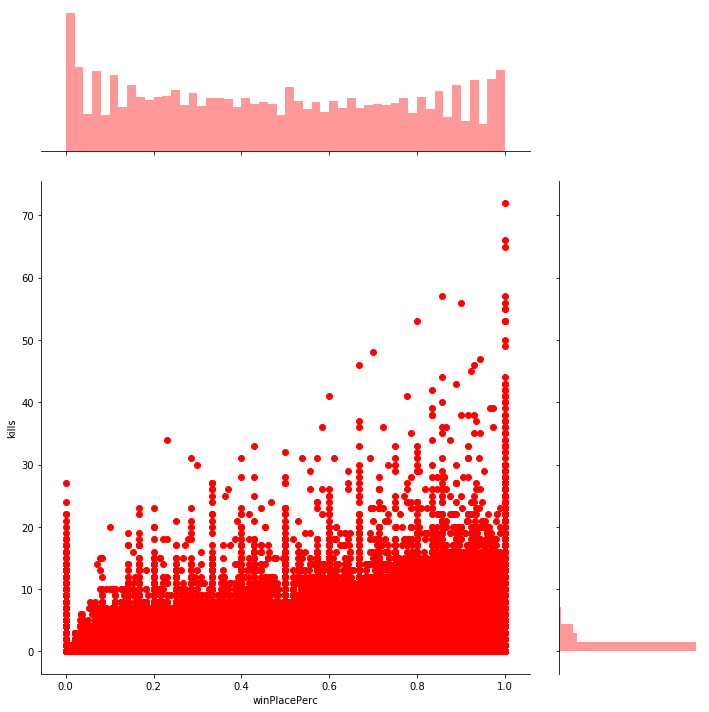

In [31]:
# 킬 수와 치킨의 상관관계
sns.jointplot(x="winPlacePerc", y="kills", data=train_df, height=10, ratio=3, color="r")
plt.show()

## winPlacePerc vs walkDistance

In [34]:
print("The average person walks for {:.1f}m, 99% of people have walked {}m or less, while the marathoner champion walked for {}m.".format(train_df['walkDistance'].mean(), train_df['walkDistance'].quantile(0.99), train_df['walkDistance'].max()))

The average person walks for 1154.2m, 99% of people have walked 4396.0m or less, while the marathoner champion walked for 25780.0m.


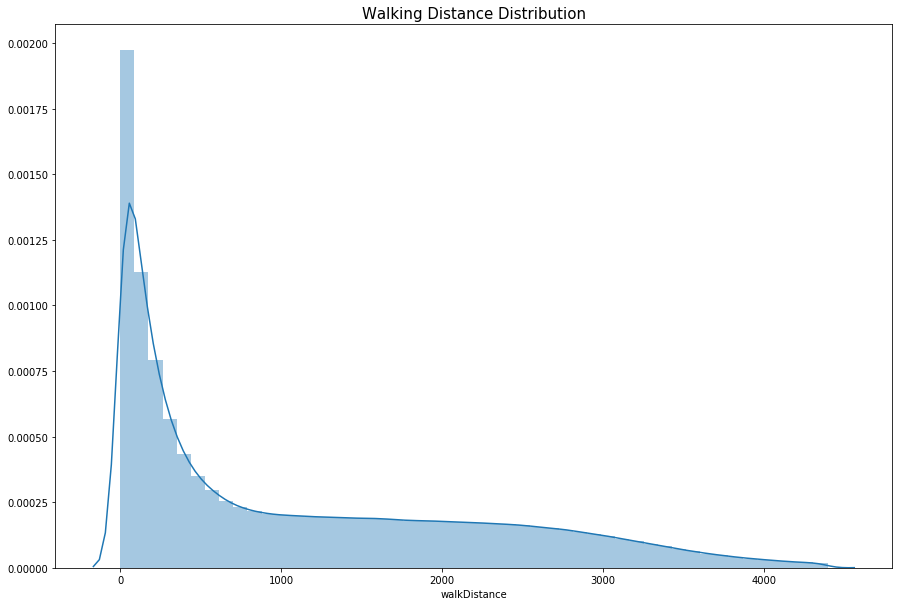

In [35]:
data = train_df.copy()
data = data[data['walkDistance'] < train_df['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

In [36]:
print("{} players ({:.4f}%) walked 0 meters. This means that they die before even taking a step or they are afk (more possible).".format(len(data[data['walkDistance'] == 0]), 100*len(data1[data1['walkDistance']==0])/len(train_df)))

99603 players (2.0329%) walked 0 meters. This means that they die before even taking a step or they are afk (more possible).


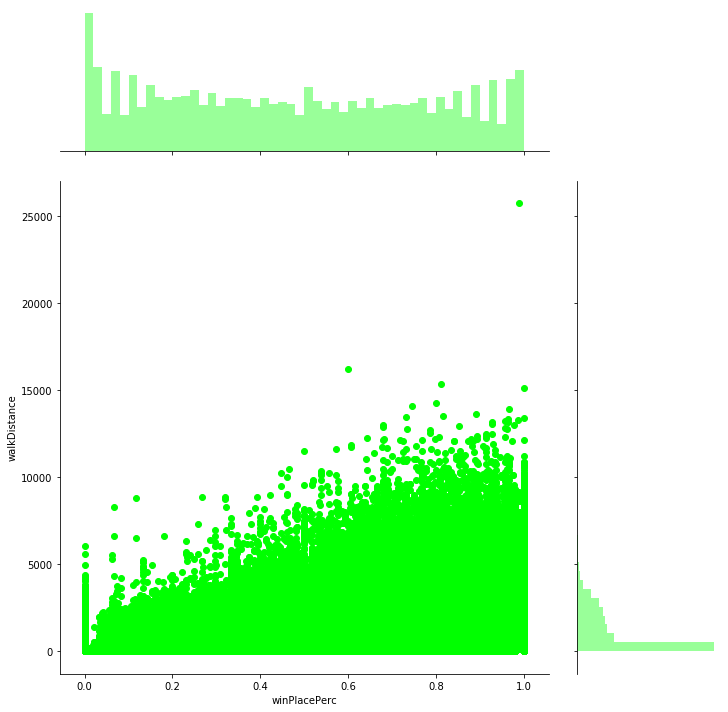

In [37]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train_df, height=10, ratio=3, color="lime")
plt.show()

## winPlacePerc vs assist

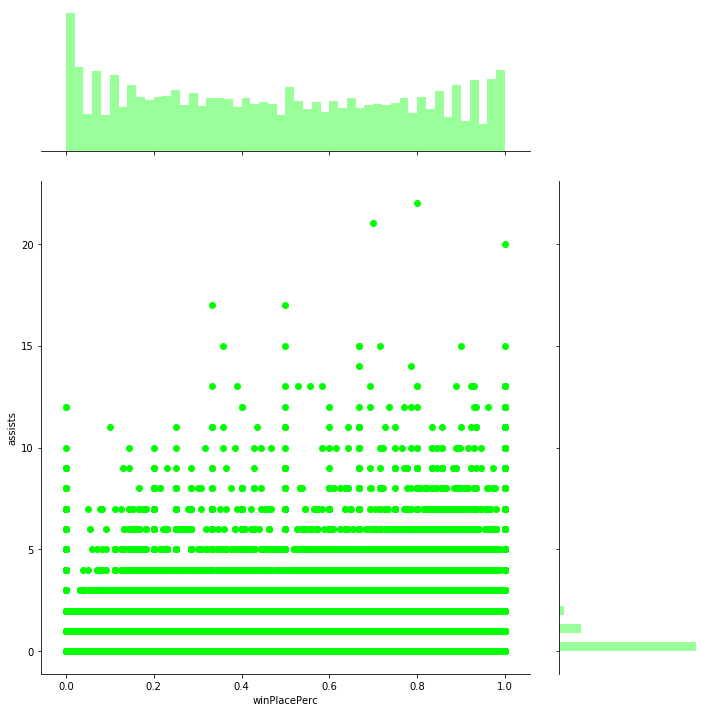

In [38]:
sns.jointplot(x="winPlacePerc", y="assists",  data=train_df, height=10, ratio=3, color="lime")
plt.show()

## winPlacePerc vs boosts

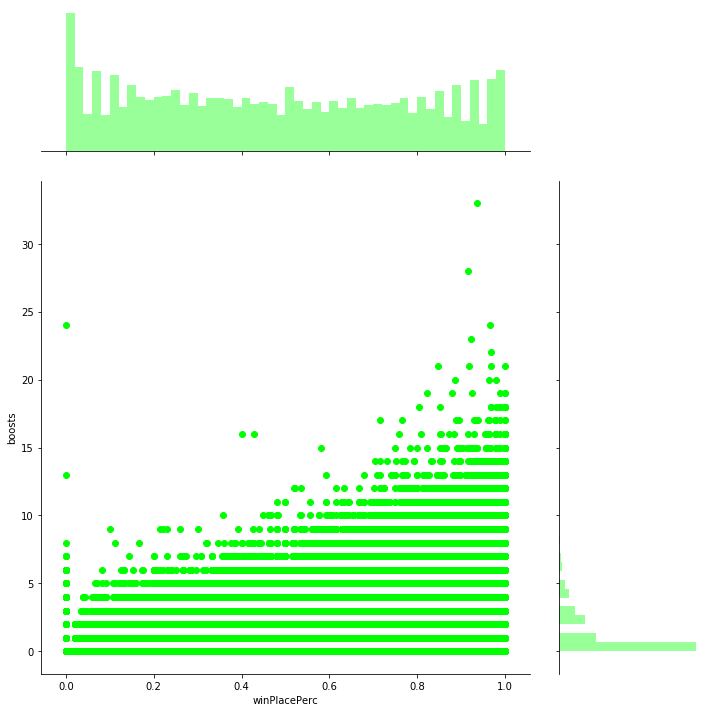

In [40]:
sns.jointplot(x="winPlacePerc", y="boosts",  data=train_df, height=10, ratio=3, color="lime")
plt.show()

## winPlacePerc vs headshotKills

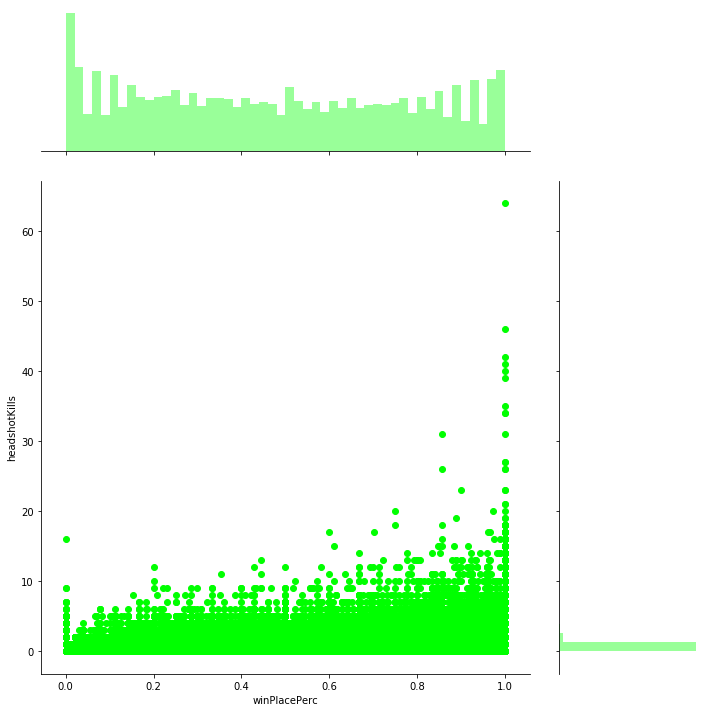

In [46]:
sns.jointplot(x="winPlacePerc", y="headshotKills",  data=train_df, height=10, ratio=3, color="lime")
plt.show()

## winPlacePerc vs heals

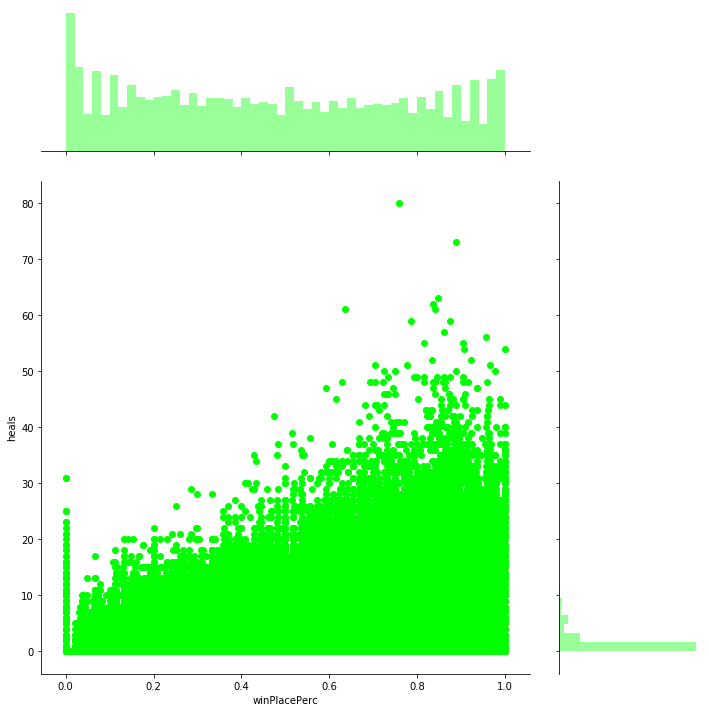

In [47]:
sns.jointplot(x="winPlacePerc", y="heals",  data=train_df, height=10, ratio=3, color="lime")
plt.show()

## winPlacePerc vs longestKill

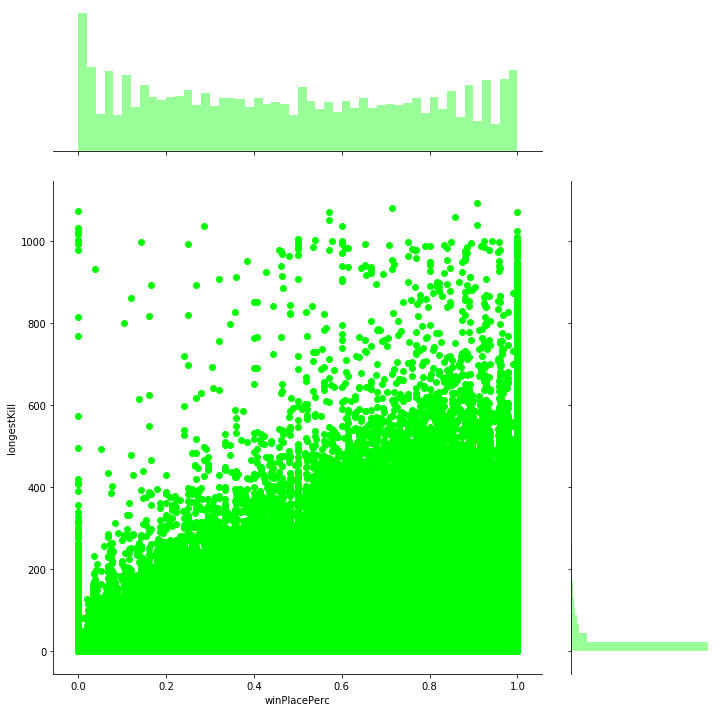

In [48]:
sns.jointplot(x="winPlacePerc", y="longestKill",  data=train_df, height=10, ratio=3, color="lime")
plt.show()

## winPlacePerc vs matchDuration

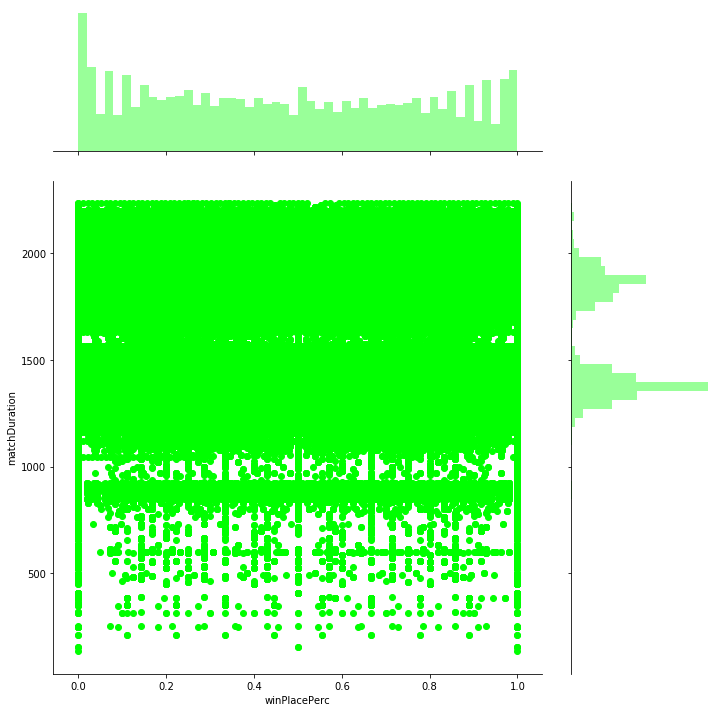

In [49]:
sns.jointplot(x="winPlacePerc", y="matchDuration",  data=train_df, height=10, ratio=3, color="lime")
plt.show()

## winPlacePerc vs swimDistance

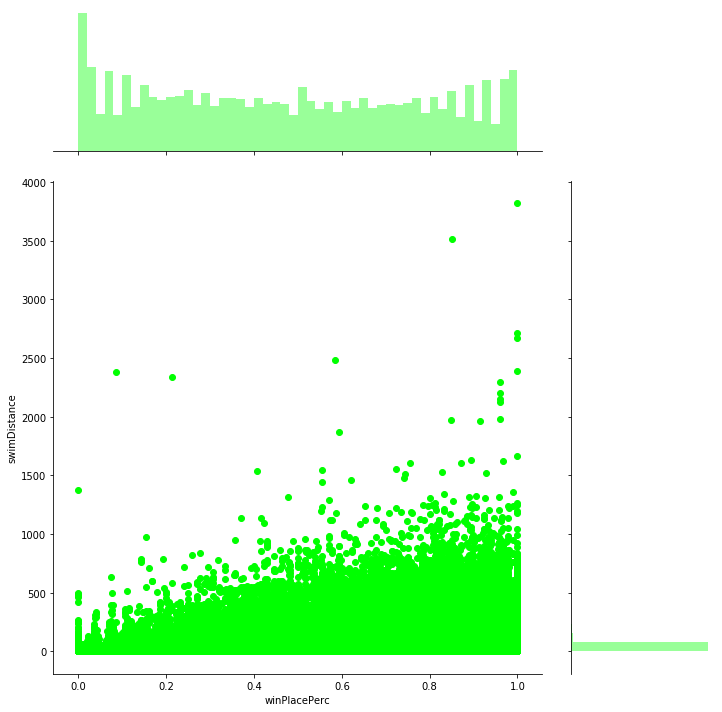

In [50]:
sns.jointplot(x="winPlacePerc", y="swimDistance",  data=train_df, height=10, ratio=3, color="lime")
plt.show()

## winPlacePerc vs weaponsAcquired


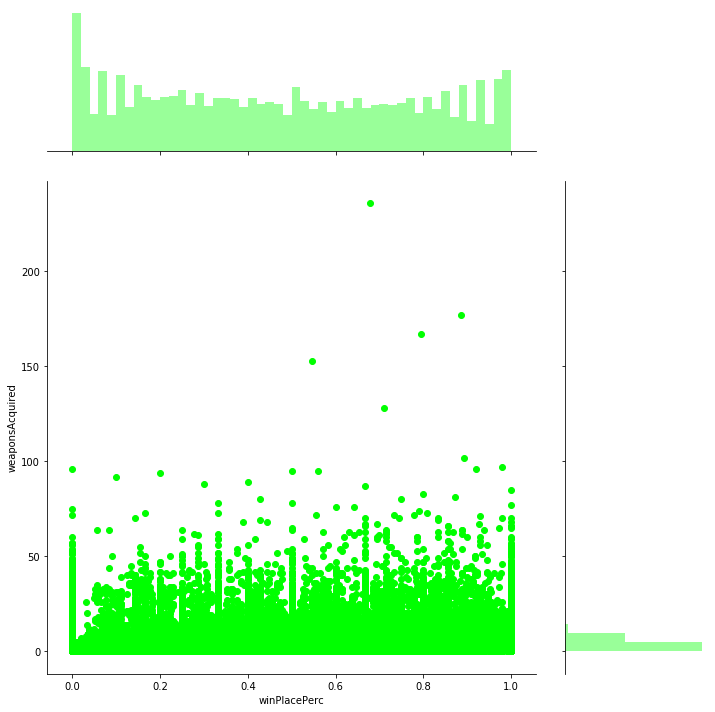

In [51]:
sns.jointplot(x="winPlacePerc", y="weaponsAcquired",  data=train_df, height=10, ratio=3, color="lime")
plt.show()

## winPlacePerc vs rideDistance

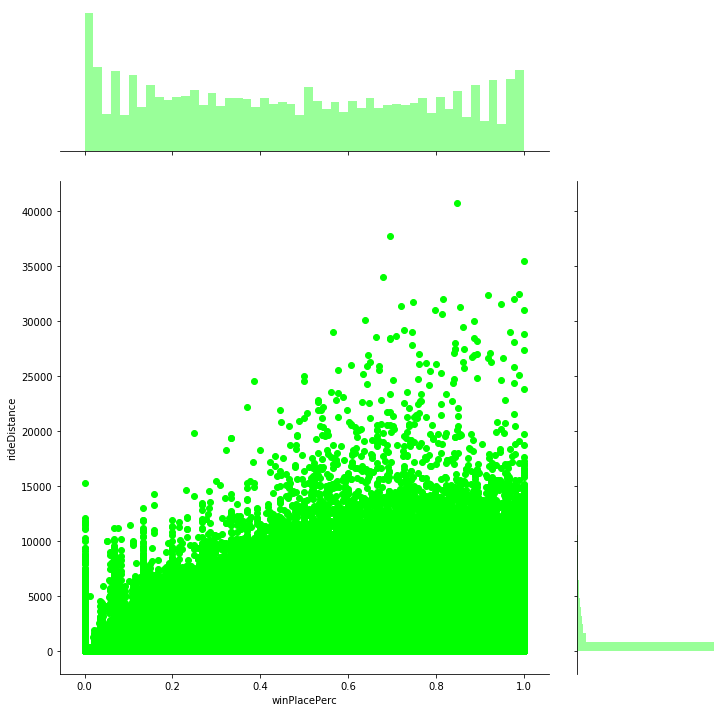

In [52]:
sns.jointplot(x="winPlacePerc", y="rideDistance",  data=train_df, height=10, ratio=3, color="lime")
plt.show()

## Pearson correlation between variables

In [48]:
train_df.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
Id,,,,,,,,,,,,,,,,,,,,,
7f96b2f878858a,0,0,0.00,0,0,0,60,1241,0,0,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
eef90569b9d03c,0,0,91.47,0,0,0,57,0,0,0,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
1eaf90ac73de72,1,0,68.00,0,0,0,47,0,0,0,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
4616d365dd2853,0,0,32.90,0,0,0,75,0,0,0,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
315c96c26c9aac,0,0,100.00,0,0,0,45,0,1,1,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [52]:
train_df['winPlacePerc'].mean()

0.472821552721927

In [51]:
train_df['longestKill']

Id
7f96b2f878858a     0.00
eef90569b9d03c     0.00
1eaf90ac73de72     0.00
4616d365dd2853     0.00
315c96c26c9aac    58.53
                  ...  
afff7f652dbc10     0.00
f4197cf374e6c0     0.00
e1948b1295c88a     0.00
cc032cdd73b7ac    98.50
0d8e7ed728b6fd    78.25
Name: longestKill, Length: 4446966, dtype: float64

In [43]:
dataset = train_df.values

In [44]:
dataset

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.466e+03,
        4.444e-01],
       [0.000e+00, 0.000e+00, 9.147e+01, ..., 5.000e+00, 0.000e+00,
        6.400e-01],
       [1.000e+00, 0.000e+00, 6.800e+01, ..., 2.000e+00, 0.000e+00,
        7.755e-01],
       ...,
       [0.000e+00, 0.000e+00, 5.906e+01, ..., 4.000e+00, 0.000e+00,
        4.815e-01],
       [0.000e+00, 4.000e+00, 1.804e+02, ..., 8.000e+00, 0.000e+00,
        8.000e-01],
       [0.000e+00, 2.000e+00, 2.680e+02, ..., 5.000e+00, 0.000e+00,
        5.464e-01]])

In [60]:
dataset.shape

(4446966, 25)

In [67]:
X = dataset[:,0:24]
Y = dataset[:,24]

In [66]:
X

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 2.448e+02, 1.000e+00,
        1.466e+03],
       [0.000e+00, 0.000e+00, 9.147e+01, ..., 1.434e+03, 5.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 6.800e+01, ..., 1.618e+02, 2.000e+00,
        0.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 5.906e+01, ..., 7.887e+02, 4.000e+00,
        0.000e+00],
       [0.000e+00, 4.000e+00, 1.804e+02, ..., 2.748e+03, 8.000e+00,
        0.000e+00],
       [0.000e+00, 2.000e+00, 2.680e+02, ..., 1.244e+03, 5.000e+00,
        0.000e+00]])

In [70]:
# 딥러닝을 구동하는 데 필요한 케라스 함수를 불러옵니다.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# 필요한 라이브러리를 불러옵니다.
import tensorflow as tf

# 실행할 때마다 같은 결과를 출력하기 위해 설정하는 부분입니다.
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [75]:
model = Sequential()

model.add(Dense(100, input_dim=24, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [77]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

In [78]:
model.fit(X_train, Y_train, epochs=10, batch_size=10000)

Epoch 1/10
312/312 [==============================] - 3s 9ms/step - loss: 0.0979 - accuracy: 0.0770
Epoch 2/10
312/312 [==============================] - 3s 10ms/step - loss: 0.0890 - accuracy: 0.0769
Epoch 3/10
312/312 [==============================] - 3s 10ms/step - loss: 0.0476 - accuracy: 0.0764
Epoch 4/10
312/312 [==============================] - 3s 9ms/step - loss: 0.0228 - accuracy: 0.0771
Epoch 5/10
312/312 [==============================] - 3s 9ms/step - loss: 0.0174 - accuracy: 0.0771
Epoch 6/10
312/312 [==============================] - 3s 9ms/step - loss: 0.0150 - accuracy: 0.0771
Epoch 7/10
312/312 [==============================] - 3s 9ms/step - loss: 0.0142 - accuracy: 0.0771
Epoch 8/10
312/312 [==============================] - 3s 9ms/step - loss: 0.0135 - accuracy: 0.0771
Epoch 9/10
312/312 [==============================] - 3s 9ms/step - loss: 0.0131 - accuracy: 0.0772
Epoch 10/10
312/312 [==============================] - 3s 9ms/step - loss: 0.0128 - accuracy: 0.07

In [79]:
print("\n Accuracy: %.4f" % (model.evaluate(X, Y)[1]))

138968/138968 [==============================] - 90s 646us/step - loss: nan - accuracy: 0.0773

 Accuracy: 0.0773


In [80]:
dataset1 = train_df.values

In [87]:
train_df['longestKill']

0           0.00
1           0.00
2           0.00
3           0.00
4          58.53
           ...  
4446961     0.00
4446962     0.00
4446963     0.00
4446964    98.50
4446965    78.25
Name: longestKill, Length: 4446966, dtype: float64

In [83]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 25 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int64  
 1   boosts           int64  
 2   damageDealt      float64
 3   DBNOs            int64  
 4   headshotKills    int64  
 5   heals            int64  
 6   killPlace        int64  
 7   killPoints       int64  
 8   kills            int64  
 9   killStreaks      int64  
 10  longestKill      float64
 11  matchDuration    int64  
 12  maxPlace         int64  
 13  numGroups        int64  
 14  rankPoints       int64  
 15  revives          int64  
 16  rideDistance     float64
 17  roadKills        int64  
 18  swimDistance     float64
 19  teamKills        int64  
 20  vehicleDestroys  int64  
 21  walkDistance     float64
 22  weaponsAcquired  int64  
 23  winPoints        int64  
 24  winPlacePerc     float64
dtypes: float64(6), int64(19)
memory usage: 848.2 MB


In [90]:
X1 = dataset[:,10]
Y1 = dataset[:,24]

In [85]:
X1

array([ 0.  ,  0.  ,  0.  , ...,  0.  , 98.5 , 78.25])

In [92]:
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.3, random_state=seed)

In [93]:
model = Sequential()

model.add(Dense(100, input_dim=1, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [94]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

In [95]:
model.fit(X_train, Y_train, epochs=10, batch_size=10000)

Epoch 1/10
312/312 [==============================] - 3s 8ms/step - loss: 0.0789 - accuracy: 0.0712: 0s - l
Epoch 2/10
312/312 [==============================] - 3s 8ms/step - loss: 0.0723 - accuracy: 0.0721
Epoch 3/10
312/312 [==============================] - 3s 9ms/step - loss: 0.0721 - accuracy: 0.0721
Epoch 4/10
312/312 [==============================] - 3s 9ms/step - loss: 0.0720 - accuracy: 0.0721: 0s - loss: 0.0720 - accu
Epoch 5/10
312/312 [==============================] - 3s 9ms/step - loss: 0.0719 - accuracy: 0.0721
Epoch 6/10
312/312 [==============================] - 3s 8ms/step - loss: 0.0719 - accuracy: 0.0721
Epoch 7/10
312/312 [==============================] - 3s 9ms/step - loss: 0.0719 - accuracy: 0.0721
Epoch 8/10
312/312 [==============================] - 3s 8ms/step - loss: 0.0719 - accuracy: 0.0721
Epoch 9/10
312/312 [==============================] - 3s 8ms/step - loss: 0.0719 - accuracy: 0.0721
Epoch 10/10
312/312 [==============================] - 3s 10ms/ste

In [96]:
print("\n Accuracy: %.4f" % (model.evaluate(X1, Y1)[1]))

138968/138968 [==============================] - 88s 632us/step - loss: nan - accuracy: 0.0721

 Accuracy: 0.0721


In [97]:
df = train_df

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 25 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int64  
 1   boosts           int64  
 2   damageDealt      float64
 3   DBNOs            int64  
 4   headshotKills    int64  
 5   heals            int64  
 6   killPlace        int64  
 7   killPoints       int64  
 8   kills            int64  
 9   killStreaks      int64  
 10  longestKill      float64
 11  matchDuration    int64  
 12  maxPlace         int64  
 13  numGroups        int64  
 14  rankPoints       int64  
 15  revives          int64  
 16  rideDistance     float64
 17  roadKills        int64  
 18  swimDistance     float64
 19  teamKills        int64  
 20  vehicleDestroys  int64  
 21  walkDistance     float64
 22  weaponsAcquired  int64  
 23  winPoints        int64  
 24  winPlacePerc     float64
dtypes: float64(6), int64(19)
memory usage: 848.2 MB


In [101]:
# del df['assists']
del df['DBNOs']
del df['killPlace']
del df['teamKills']
del df['vehicleDestroys']
del df['weaponsAcquired']
del df['killStreaks']
del df['maxPlace']
del df['winPoints']
del df['matchDuration']
del df['revives']


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   boosts         int64  
 1   damageDealt    float64
 2   headshotKills  int64  
 3   heals          int64  
 4   killPoints     int64  
 5   kills          int64  
 6   longestKill    float64
 7   numGroups      int64  
 8   rankPoints     int64  
 9   rideDistance   float64
 10  roadKills      int64  
 11  swimDistance   float64
 12  walkDistance   float64
 13  winPlacePerc   float64
dtypes: float64(6), int64(8)
memory usage: 475.0 MB


In [103]:
pubgset = df.values

In [113]:
x = pubgset[:,0:13]
y = pubgset[:,13]

In [116]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

In [125]:
model1 = Sequential()

model1.add(Dense(100, input_dim=13, activation='relu'))
model1.add(Dense(70, activation='relu'))
model1.add(Dense(50, activation='relu'))
model1.add(Dense(30, activation='relu'))
model1.add(Dense(10, activation='relu'))
model1.add(Dense(1)

SyntaxError: unexpected EOF while parsing (<ipython-input-125-6f082e240e22>, line 8)

In [124]:
model1.fit(X_train, Y_train, epochs=10, batch_size=100)

Epoch 1/10
31129/31129 [==============================] - 17s 535us/step - loss: 568285.6875 - accuracy: 8.6415e-05
Epoch 2/10
31129/31129 [==============================] - 16s 530us/step - loss: 568285.0000 - accuracy: 8.6415e-05
Epoch 3/10
31129/31129 [==============================] - 19s 607us/step - loss: 568285.3750 - accuracy: 8.6415e-05
Epoch 4/10
31129/31129 [==============================] - 18s 568us/step - loss: 568284.8750 - accuracy: 8.6415e-05
Epoch 5/10
31129/31129 [==============================] - 17s 545us/step - loss: 568284.0000 - accuracy: 8.6415e-05
Epoch 6/10
31129/31129 [==============================] - 18s 564us/step - loss: 568285.5000 - accuracy: 8.6415e-05
Epoch 7/10
31129/31129 [==============================] - 18s 584us/step - loss: 568284.6250 - accuracy: 8.6415e-05
Epoch 8/10
31129/31129 [==============================] - 19s 625us/step - loss: 568285.2500 - accuracy: 8.6415e-05
Epoch 9/10
31129/31129 [==============================] - 19s 621us/step

In [126]:
print("\n Accuracy: %.4f" % (model1.evaluate(x, y)[1]))

138968/138968 [==============================] - 75s 541us/step - loss: nan - accuracy: 9.0174e-05

 Accuracy: 0.0001


In [127]:
from sklearn import datasets, model_selection
from tensorflow.keras.utils import to_categorical 

In [128]:
x = tf.placeholder(tf.float32,[None,14]) #n행 4열짜리 잡는다? 플레이스홀더 잡는것이 뭐지
y = y_train
w = tf.Variable(tf.random_uniform([14,1]))
b = tf.Variable(tf.random_uniform([1]))

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [132]:
X_train.shape

(3112876, 13)

In [133]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection
import seaborn as sns
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

In [134]:
x = tf.placeholder( tf.float32, [None,13])
y = tf.constant( Y_train, tf.float32)

AttributeError: module 'tensorflow' has no attribute 'placeholder'